In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from src import classes as c
from src import functions as f
import matplotlib.pyplot as plt
import seaborn as sns

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

In [5]:
preprocessing = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))

In [6]:
sm = SMOTE(random_state=2021)

In [7]:
# creating f1 scorer
f1 = f.f1

In [8]:
modeling = c.Harness(f1)

## Baseline Model

Dropping engineered features to establish the baseline score.

In [9]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [10]:
base_df = f.framer(df, [], feature_list)

In [11]:
base_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1,NA,None,7500,1984,M,Black,Asian,Male,NA,NA,NA,SOUTH PCT 1ST W - ROBERT,0,0,South,O,O2
1,0,NA,None,5670,1965,M,White,NA,NA,NA,NA,NA,NA,0,0,NA,NA,NA


In [12]:
X, y = f.Xy(base_df)

In [13]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [14]:
preprocessing.fit_transform(X_train);

In [15]:
clf = LogisticRegression(max_iter=1000)

In [16]:
baseline = make_pipeline(preprocessing, clf)

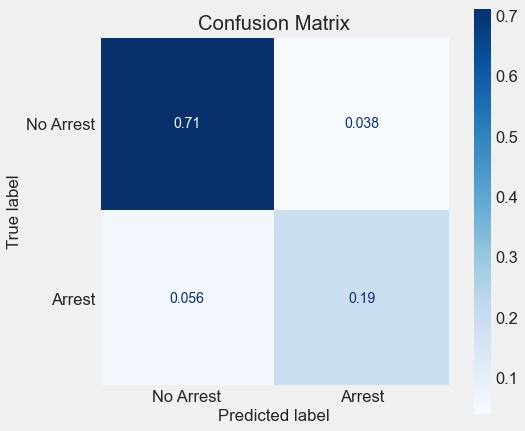

In [17]:
f.confusion(baseline, X_train, y_train)

In [18]:
modeling.report(baseline, X_train, y_train, 'Baseline', 'Log Reg w/ all base cols')

Baseline has an average F1 of 0.7687569287145607


array([0.77939863, 0.75540865, 0.76701878, 0.7742515 , 0.76770708])

In [19]:
model1 = make_sm_pipeline(preprocessing, sm, clf)

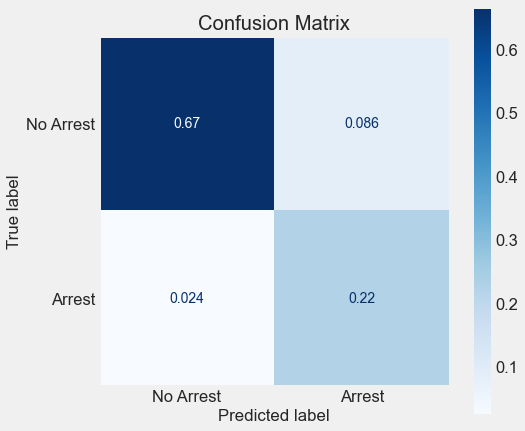

In [20]:
f.confusion(model1, X_train, y_train)

In [21]:
modeling.report(model1, X_train, y_train, 'Baseline_SM', 'baseline w/ SMOTE')

Baseline_SM has an average F1 of 0.7708287135918668


array([0.77300613, 0.75807278, 0.7735369 , 0.78033635, 0.7691914 ])

In [22]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.768757,Log Reg w/ all base cols
1,Baseline_SM,0.770829,baseline w/ SMOTE


## Engineered Features
Engineered columns from original EDA:

'Weapon Flag', 'Reported Year', 'Reported Month', 'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag'

In [23]:
for feature in feature_list:
    feature_df = f.framer(df, [feature], feature_list)
    X, y = f.Xy(feature_df)
    X_train, X_test, y_train, y_test = f.splitter(X,y)
    feature_pipe = make_sm_pipeline(preprocessing, sm, clf)
    modeling.report(feature_pipe, X_train, y_train, f'{feature} model', f'{feature} added')

Weapon Flag model has an average F1 of 0.7712584411635183
Reported Year model has an average F1 of 0.7714294524613967
Reported Month model has an average F1 of 0.7702852091450928
Day of Month model has an average F1 of 0.7693219389581039
Day of Week model has an average F1 of 0.7705544122126456
Reported Hour model has an average F1 of 0.7699422932799156
Beat Flag model has an average F1 of 0.7718025558909024


In [24]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.768757,Log Reg w/ all base cols
1,Day of Month model,0.769322,Day of Month added
2,Reported Hour model,0.769942,Reported Hour added
3,Reported Month model,0.770285,Reported Month added
4,Day of Week model,0.770554,Day of Week added
5,Baseline_SM,0.770829,baseline w/ SMOTE
6,Weapon Flag model,0.771258,Weapon Flag added
7,Reported Year model,0.771429,Reported Year added
8,Beat Flag model,0.771803,Beat Flag added
